# Use Seq2Seq Model to Predict the Calibrations (v2.0)

## Update:
+ **Data preprocessing**: remove data which has small luminosity (i.e., remove luminosity <= some threshold epsilon) so that the calibration recovery parts will be removed.
+ **Data visualization**: improve the data visualization code to clearly seperate the data in luminosity recovery part from the entire sequence.

## Settings:
+ **Input**: the previous calibrations and luminosity;
+ **Output**: the future calibrations;
+ **Training data**: the data collected from the crystal 54,000 in the year of 2016.

## Two Cases:
1. **Case1**: We **do not** reuse the predicted values. For example, we **do not** use the predicted values at *t* to predict the *t+1* values. 
2. **Case2**: We **do** reuse the predicted values. For example, we **do** use the predicted values at *t* to predict the *t+1* values. 

## Main:
This is the main function/entry for our Seq2Seq model.

### Import packages/classes.
+ **seq2seq_model** defines the model;
+ **seq2seq_train** defines the training procedures;
+ **seq2seq_prediction** defines the prediction procedures;
+ **ecal_dataset_prep** defines the data preprocessing procedures.

In [1]:
import importlib
import seq2seq_train
import ecal_dataset_prep
import seq2seq_prediction
importlib.reload(seq2seq_train)
importlib.reload(ecal_dataset_prep)
importlib.reload(seq2seq_prediction)
from seq2seq_train import *  # re-import everything from the module


/home/mohamad-khaled-charaf/miniconda3/envs/fair_gpu/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#------ import packages ------#
from seq2seq_model import *
from seq2seq_train import *
from seq2seq_prediction import *
from ecal_dataset_prep import *

### Set up the hyper-parameters.
+ **input_len**: the time steps (sequence length) for input data;
+ **output_len**: the time steps (sequence length) for output data;
+ **stride**: the stide of the sequence/window (default: output_len);
+ **learning_rate**: the learning rate for our model;
+ **n_epochs**: the maximum epoch to train our model;
+ **print_step**: we print the training information per "print_step" epoch;
+ **batch_size**: the batch size to train our model;
+ **opt_alg**: the name of the optimization function (one should select one from {adam', 'sgd'});
+ **train_strategy**: different training strategies (one should select one from {'recursive', 'teacher_forcing', 'mixed'});
+ **teacher_forcing_ratio**: it is a float number in the range of 0-1; it will be ignored when train_strategy='recursive';
+ **hidden_size**: the number of features in the hidden state;
+ **num_layers**: the number of recurrent layers;
+ **gpu_id**: the gpu id;
+ **train_file**: the training csv file;
+ **val_file**: the validation csv file;
+ **test_file**: the test csv file;
+ **crystal_id**: the crystal's id;
+ **verbose**:set it to be True if print information is desired; otherwise, set it to False; default (False).

In [3]:
input_len = 24
output_len = 24
stride = output_len
learning_rate = 1e-3
n_epochs = 500 # Default:n_epochs = 200. Can be adjusted
print_step = 1
batch_size = 16 # batch_size = 128 if luminosity threshold = 0
if output_len>=48: batch_size = 32
opt_alg = 'adam'
train_strategy = 'teacher_forcing' #"Please select one of them---[recursive, teacher_forcing, mixed]!"
teacher_forcing_ratio = 0.5 # please set it in the range of [0,1]
hidden_size = 1024
num_layers = 2
gpu_id = 0
crystal_id = 54000
verbose = False
train_file_2016 = '../data/interim/df_skimmed_xtal_{}_2016.csv'.format(crystal_id)
test_file_2017 = '../data/interim/df_skimmed_xtal_{}_2017.csv'.format(crystal_id)
test_file_2018 = '../data/interim/df_skimmed_xtal_{}_2018.csv'.format(crystal_id)
# device = torch.device("cuda:{}".format(gpu_id) if torch.cuda.is_available() else "cpu")
device = "cpu"
lumi_threshold = 2e7 # Default: lumi_threshold = 2e7. Maximum luminosity is around 1e8. Can be adjusted

### Create folders to keep the results

In [5]:
parent_folder = 'LSTM_{}_IW_{}_OW_{}_LR_{}_Epochs_{}_ID_{}_lumi_threshold_{}'.format(hidden_size, input_len, output_len, learning_rate, n_epochs, crystal_id, lumi_threshold)

# folder to save figures
save_dir_vis_data = parent_folder + '/vis_data/' 

# folder to save models
save_dir_models = parent_folder + '/models/' 

# folders for case1
save_dir_case1_fig= parent_folder + '/case1_fig/'  
save_dir_case1_csv= parent_folder + '/case1_csv/' 

# folders for case2
save_dir_case2_fig= parent_folder + '/case2_fig/'  
save_dir_case2_csv= parent_folder + '/case2_csv/'

dir_list = [save_dir_vis_data, save_dir_case1_fig, save_dir_case1_csv, save_dir_case2_fig, save_dir_case2_csv,save_dir_models]
for cur_dir in dir_list:
    if not os.path.exists(cur_dir):
        os.makedirs(cur_dir)
        print('>>> {} has been created successfully!'.format(cur_dir))
    else:
        print('>>> {} is exist!'.format(cur_dir))

>>> LSTM_1024_IW_24_OW_24_LR_0.001_Epochs_500_ID_54000_lumi_threshold_20000000.0/vis_data/ is exist!
>>> LSTM_1024_IW_24_OW_24_LR_0.001_Epochs_500_ID_54000_lumi_threshold_20000000.0/case1_fig/ is exist!
>>> LSTM_1024_IW_24_OW_24_LR_0.001_Epochs_500_ID_54000_lumi_threshold_20000000.0/case1_csv/ is exist!
>>> LSTM_1024_IW_24_OW_24_LR_0.001_Epochs_500_ID_54000_lumi_threshold_20000000.0/case2_fig/ is exist!
>>> LSTM_1024_IW_24_OW_24_LR_0.001_Epochs_500_ID_54000_lumi_threshold_20000000.0/case2_csv/ is exist!
>>> LSTM_1024_IW_24_OW_24_LR_0.001_Epochs_500_ID_54000_lumi_threshold_20000000.0/models/ is exist!


### Visualize the datasets (only show the calibration curve).

In [6]:
# for train_file_2016
fig_name_cali = os.path.join(save_dir_vis_data, '2016_cali_original.png')
fig_name_scaled_cali = os.path.join(save_dir_vis_data, '2016_cali_scaled.png')
ecal_dataset_prep_train_2016 = ECAL_Dataset_Prep(train_file_2016, 
                                                 input_len, 
                                                 output_len, 
                                                 stride, 
                                                 fig_name_cali, 
                                                 fig_name_scaled_cali,
                                                 verbose,
                                                 lumi_threshold)
ecal_dataset_prep_train_2016.start_processing()

In [7]:
# for test_file_2017
fig_name_cali = os.path.join(save_dir_vis_data, '2017_cali_original.png')
fig_name_scaled_cali = os.path.join(save_dir_vis_data, '2017_cali_scaled.png')
ecal_dataset_prep_test_2017 = ECAL_Dataset_Prep(test_file_2017, 
                                                 input_len, 
                                                 output_len, 
                                                 stride, 
                                                 fig_name_cali, 
                                                 fig_name_scaled_cali,
                                                 verbose,
                                                 lumi_threshold)
ecal_dataset_prep_test_2017.start_processing()

In [8]:
# for test_file_2018
fig_name_cali = os.path.join(save_dir_vis_data, '2018_cali_original.png')
fig_name_scaled_cali = os.path.join(save_dir_vis_data, '2018_cali_scaled.png')
ecal_dataset_prep_test_2018 = ECAL_Dataset_Prep(test_file_2018, 
                                                 input_len, 
                                                 output_len, 
                                                 stride, 
                                                 fig_name_cali, 
                                                 fig_name_scaled_cali,
                                                 verbose,
                                                 lumi_threshold)
ecal_dataset_prep_test_2018.start_processing()

### Create Seq2Seq model including an EncoderNet and a DecoderNet

In [9]:
X_train = ecal_dataset_prep_train_2016.torch_X
Y_train = ecal_dataset_prep_train_2016.torch_Y


lstm_encoder = LSTM_Encoder(input_size=X_train.shape[2]-3, hidden_size=hidden_size, num_layers=num_layers)
lstm_decoder = LSTM_Decoder(input_size=Y_train.shape[2]-3, hidden_size=hidden_size, num_layers=num_layers)
lstm_encoder.to(device)
lstm_decoder.to(device)
print(lstm_encoder)
print(lstm_decoder)
print(X_train.shape)

LSTM_Encoder(
  (lstm): LSTM(3, 1024, num_layers=2)
)
LSTM_Decoder(
  (lstm): LSTM(3, 1024, num_layers=2)
  (linear): Linear(in_features=1024, out_features=1, bias=True)
)
torch.Size([24, 33, 6])


### Training Seq2Seq model

In [199]:
loss_figure_name = os.path.join(save_dir_vis_data, '0_loss.png')
target_len = output_len
seq2seq_train = Seq2Seq_Train(lstm_encoder,
                              lstm_decoder,
                              X_train,
                              Y_train,
                              n_epochs,
                              target_len,
                              batch_size,
                              learning_rate,
                              opt_alg,
                              print_step,
                              train_strategy,
                              teacher_forcing_ratio,
                              device,
                              loss_figure_name)
seq2seq_train.train(ecal_dataset_prep_train_2016.scaler_cali)

>>> Start training... (be patient: training time varies)
PINNS IN ACTION : 
>>>>>> 0/500 Epoch; Loss=3139.238348931074
epoch 0: data=0.3693 phys=0.0000
>>>>>> 1/500 Epoch; Loss=3136.5289306640625
epoch 1: data=9.3308 phys=34.7033
>>>>>> 2/500 Epoch; Loss=815.8003921508789
epoch 2: data=68.4927 phys=0.9318
>>>>>> 3/500 Epoch; Loss=863.8359832763672
epoch 3: data=39.1696 phys=13.2379
>>>>>> 4/500 Epoch; Loss=1427.2760620117188
epoch 4: data=45.3891 phys=11.2869
>>>>>> 5/500 Epoch; Loss=212.13028526306152
epoch 5: data=50.2275 phys=0.0003
>>>>>> 6/500 Epoch; Loss=547.2781066894531
epoch 6: data=36.7692 phys=7.4181
>>>>>> 7/500 Epoch; Loss=738.1727600097656
epoch 7: data=26.5346 phys=5.7290
>>>>>> 8/500 Epoch; Loss=99.37813949584961
epoch 8: data=17.6655 phys=0.0060
>>>>>> 9/500 Epoch; Loss=303.48685455322266
epoch 9: data=8.9460 phys=4.2227
>>>>>> 10/500 Epoch; Loss=383.38494873046875
epoch 10: data=4.4145 phys=2.9212
>>>>>> 11/500 Epoch; Loss=37.20334768295288
epoch 11: data=2.0608 phys=

>>>>>> 103/500 Epoch; Loss=0.24894829839468002
epoch 103: data=0.1969 phys=0.0000
>>>>>> 104/500 Epoch; Loss=0.2484532743692398
epoch 104: data=0.1961 phys=0.0000
>>>>>> 105/500 Epoch; Loss=0.24898643791675568
epoch 105: data=0.1964 phys=0.0000
>>>>>> 106/500 Epoch; Loss=0.24861500412225723
epoch 106: data=0.1968 phys=0.0000
>>>>>> 107/500 Epoch; Loss=0.2484338954091072
epoch 107: data=0.1963 phys=0.0000
>>>>>> 108/500 Epoch; Loss=0.2476971372961998
epoch 108: data=0.1960 phys=0.0000
>>>>>> 109/500 Epoch; Loss=0.24851172417402267
epoch 109: data=0.1967 phys=0.0000
>>>>>> 110/500 Epoch; Loss=0.24771670997142792
epoch 110: data=0.1963 phys=0.0000
>>>>>> 111/500 Epoch; Loss=0.2469812110066414
epoch 111: data=0.1945 phys=0.0000
>>>>>> 112/500 Epoch; Loss=0.2481990084052086
epoch 112: data=0.1964 phys=0.0000
>>>>>> 113/500 Epoch; Loss=0.2484137937426567
epoch 113: data=0.1975 phys=0.0000
>>>>>> 114/500 Epoch; Loss=0.24769353866577148
epoch 114: data=0.1952 phys=0.0000
>>>>>> 115/500 Epoch; 

>>>>>> 204/500 Epoch; Loss=0.07509827986359596
epoch 204: data=0.0646 phys=0.0000
>>>>>> 205/500 Epoch; Loss=0.0777059905230999
epoch 205: data=0.0673 phys=0.0000
>>>>>> 206/500 Epoch; Loss=0.0749131478369236
epoch 206: data=0.0644 phys=0.0000
>>>>>> 207/500 Epoch; Loss=0.07541010901331902
epoch 207: data=0.0679 phys=0.0000
>>>>>> 208/500 Epoch; Loss=0.07327865436673164
epoch 208: data=0.0637 phys=0.0000
>>>>>> 209/500 Epoch; Loss=0.07331046462059021
epoch 209: data=0.0646 phys=0.0000
>>>>>> 210/500 Epoch; Loss=0.071345504373312
epoch 210: data=0.0611 phys=0.0000
>>>>>> 211/500 Epoch; Loss=0.07085060328245163
epoch 211: data=0.0634 phys=0.0000
>>>>>> 212/500 Epoch; Loss=0.0716095007956028
epoch 212: data=0.0635 phys=0.0000
>>>>>> 213/500 Epoch; Loss=0.07039719820022583
epoch 213: data=0.0624 phys=0.0000
>>>>>> 214/500 Epoch; Loss=0.07080241851508617
epoch 214: data=0.0621 phys=0.0000
>>>>>> 215/500 Epoch; Loss=0.06991171650588512
epoch 215: data=0.0613 phys=0.0000
>>>>>> 216/500 Epoch;

>>>>>> 304/500 Epoch; Loss=0.06059452146291733
epoch 304: data=0.0602 phys=0.0000
>>>>>> 305/500 Epoch; Loss=0.05895469896495342
epoch 305: data=0.0575 phys=0.0000
>>>>>> 306/500 Epoch; Loss=0.05471884459257126
epoch 306: data=0.0532 phys=0.0000
>>>>>> 307/500 Epoch; Loss=0.05435597896575928
epoch 307: data=0.0535 phys=0.0000
>>>>>> 308/500 Epoch; Loss=0.05415785312652588
epoch 308: data=0.0531 phys=0.0000
>>>>>> 309/500 Epoch; Loss=0.05329381674528122
epoch 309: data=0.0517 phys=0.0000
>>>>>> 310/500 Epoch; Loss=0.05213191360235214
epoch 310: data=0.0509 phys=0.0000
>>>>>> 311/500 Epoch; Loss=0.05087791010737419
epoch 311: data=0.0499 phys=0.0000
>>>>>> 312/500 Epoch; Loss=0.05009869672358036
epoch 312: data=0.0489 phys=0.0000
>>>>>> 313/500 Epoch; Loss=0.04945569857954979
epoch 313: data=0.0487 phys=0.0000
>>>>>> 314/500 Epoch; Loss=0.04876708984375
epoch 314: data=0.0479 phys=0.0000
>>>>>> 315/500 Epoch; Loss=0.04941365122795105
epoch 315: data=0.0495 phys=0.0000
>>>>>> 316/500 Epoc

>>>>>> 404/500 Epoch; Loss=0.037754958495497704
epoch 404: data=0.0372 phys=0.0000
>>>>>> 405/500 Epoch; Loss=0.03650371916592121
epoch 405: data=0.0361 phys=0.0000
>>>>>> 406/500 Epoch; Loss=0.03657068870961666
epoch 406: data=0.0359 phys=0.0000
>>>>>> 407/500 Epoch; Loss=0.03599911369383335
epoch 407: data=0.0353 phys=0.0000
>>>>>> 408/500 Epoch; Loss=0.03622817248106003
epoch 408: data=0.0358 phys=0.0000
>>>>>> 409/500 Epoch; Loss=0.03609301894903183
epoch 409: data=0.0352 phys=0.0000
>>>>>> 410/500 Epoch; Loss=0.03551592119038105
epoch 410: data=0.0348 phys=0.0000
>>>>>> 411/500 Epoch; Loss=0.03568117506802082
epoch 411: data=0.0351 phys=0.0000
>>>>>> 412/500 Epoch; Loss=0.0352637842297554
epoch 412: data=0.0345 phys=0.0000
>>>>>> 413/500 Epoch; Loss=0.034855665639042854
epoch 413: data=0.0342 phys=0.0000
>>>>>> 414/500 Epoch; Loss=0.0349104180932045
epoch 414: data=0.0344 phys=0.0000
>>>>>> 415/500 Epoch; Loss=0.03559844568371773
epoch 415: data=0.0351 phys=0.0000
>>>>>> 416/500 E

### Save trained models

In [200]:
#after training, we also want to save our models
model_file_name = os.path.join(save_dir_models, 'lstm_encoder.pt')
save_model(lstm_encoder.eval(), model_file_name)
model_file_name = os.path.join(save_dir_models, 'lstm_decoder.pt')
save_model(lstm_decoder.eval(), model_file_name)

The trained model has been saved!
The trained model has been saved!


### Case1 Prediction:  do not use predictions as input to help the next-round prediction

In [201]:
# check its prediction on training data
# Please note that here, the data are in the numpy format, not the tensor format
Xtrain = ecal_dataset_prep_train_2016.np_X
Ytrain = ecal_dataset_prep_train_2016.np_Y
df = ecal_dataset_prep_train_2016.df_lumi
scaler_cali = ecal_dataset_prep_train_2016.scaler_cali
year = '2016'
test_case = 'case1'
fig_name_mape = os.path.join(save_dir_case1_fig, '0_MAPE_{}_{}.png'.format(test_case,year))
fig_name_mse = os.path.join(save_dir_case1_fig, '1_MSE_{}_{}.png'.format(test_case,year))
metric_file = os.path.join(save_dir_case1_csv, '{}_{}.csv'.format(test_case,year))
seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                        lstm_decoder,
                                        Xtrain,
                                        Ytrain,
                                        df,
                                        scaler_cali,
                                        device,
                                        fig_name_mape,
                                        fig_name_mse,
                                        metric_file,
                                        test_case)
seq2seq_prediction.start_prediction()

>>>  case1 : start prediction...(be patient)
>>> Finish prediction!


In [203]:
# check its prediction on test data-2017
# Please note that here, the data are in the numpy format, not the tensor format
Xtrain = ecal_dataset_prep_test_2017.np_X
Ytrain = ecal_dataset_prep_test_2017.np_Y
df = ecal_dataset_prep_test_2017.df_lumi
scaler_cali = ecal_dataset_prep_test_2017.scaler_cali
year = '2017'
test_case = 'case1'
fig_name_mape = os.path.join(save_dir_case1_fig, '0_MAPE_{}_{}.png'.format(test_case,year))
fig_name_mse = os.path.join(save_dir_case1_fig, '1_MSE_{}_{}.png'.format(test_case,year))
metric_file = os.path.join(save_dir_case1_csv, '{}_{}.csv'.format(test_case,year))
seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                        lstm_decoder,
                                        Xtrain,
                                        Ytrain,
                                        df,
                                        scaler_cali,
                                        device,
                                        fig_name_mape,
                                        fig_name_mse,
                                        metric_file,
                                        test_case)
seq2seq_prediction.start_prediction()

>>>  case1 : start prediction...(be patient)
>>> Finish prediction!


In [204]:
# check its prediction on test data-2018
# Please note that here, the data are in the numpy format, not the tensor format
Xtrain = ecal_dataset_prep_test_2018.np_X
Ytrain = ecal_dataset_prep_test_2018.np_Y
df = ecal_dataset_prep_test_2018.df_lumi
scaler_cali = ecal_dataset_prep_test_2017.scaler_cali
year = '2018'
test_case = 'case1'
fig_name_mape = os.path.join(save_dir_case1_fig, '0_MAPE_{}_{}.png'.format(test_case,year))
fig_name_mse = os.path.join(save_dir_case1_fig, '1_MSE_{}_{}.png'.format(test_case,year))
metric_file = os.path.join(save_dir_case1_csv, '{}_{}.csv'.format(test_case,year))
seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                        lstm_decoder,
                                        Xtrain,
                                        Ytrain,
                                        df,
                                        scaler_cali,
                                        device,
                                        fig_name_mape,
                                        fig_name_mse,
                                        metric_file,
                                        test_case)
seq2seq_prediction.start_prediction()

>>>  case1 : start prediction...(be patient)
>>> Finish prediction!


### Case2 Prediction: use predictions as input to help the next-round prediction.

In [205]:
# check its prediction on training data
# Please note that here, the data are in the numpy format, not the tensor format
Xtrain = ecal_dataset_prep_train_2016.np_X
Ytrain = ecal_dataset_prep_train_2016.np_Y
df = ecal_dataset_prep_train_2016.df_lumi
scaler_cali = ecal_dataset_prep_train_2016.scaler_cali
year = '2016'
test_case = 'case2'
fig_name_mape = os.path.join(save_dir_case2_fig, '0_MAPE_{}_{}.png'.format(test_case,year))
fig_name_mse = os.path.join(save_dir_case2_fig, '1_MSE_{}_{}.png'.format(test_case,year))
metric_file = os.path.join(save_dir_case2_csv, '{}_{}.csv'.format(test_case,year))
seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                        lstm_decoder,
                                        Xtrain,
                                        Ytrain,
                                        df,
                                        scaler_cali,
                                        device,
                                        fig_name_mape,
                                        fig_name_mse,
                                        metric_file,
                                        test_case)
seq2seq_prediction.start_prediction()

>>>  case2 : start prediction...(be patient)
>>> Finish prediction!


In [206]:
# check its prediction on test data-2017
# Please note that here, the data are in the numpy format, not the tensor format
Xtrain = ecal_dataset_prep_test_2017.np_X
Ytrain = ecal_dataset_prep_test_2017.np_Y
df = ecal_dataset_prep_test_2017.df_lumi
scaler_cali = ecal_dataset_prep_test_2017.scaler_cali
year = '2017'
test_case = 'case2'
fig_name_mape = os.path.join(save_dir_case2_fig, '0_MAPE_{}_{}.png'.format(test_case,year))
fig_name_mse = os.path.join(save_dir_case2_fig, '1_MSE_{}_{}.png'.format(test_case,year))
metric_file = os.path.join(save_dir_case2_csv, '{}_{}.csv'.format(test_case,year))
seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                        lstm_decoder,
                                        Xtrain,
                                        Ytrain,
                                        df,
                                        scaler_cali,
                                        device,
                                        fig_name_mape,
                                        fig_name_mse,
                                        metric_file,
                                        test_case)
seq2seq_prediction.start_prediction()

>>>  case2 : start prediction...(be patient)
>>> Finish prediction!


In [207]:
# check its prediction on test data-2018
# Please note that here, the data are in the numpy format, not the tensor format
Xtrain = ecal_dataset_prep_test_2018.np_X
Ytrain = ecal_dataset_prep_test_2018.np_Y
df = ecal_dataset_prep_test_2018.df_lumi
scaler_cali = ecal_dataset_prep_test_2017.scaler_cali
year = '2018'
test_case = 'case2'
fig_name_mape = os.path.join(save_dir_case2_fig, '0_MAPE_{}_{}.png'.format(test_case,year))
fig_name_mse = os.path.join(save_dir_case2_fig, '1_MSE_{}_{}.png'.format(test_case,year))
metric_file = os.path.join(save_dir_case2_csv, '{}_{}.csv'.format(test_case,year))
seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                        lstm_decoder,
                                        Xtrain,
                                        Ytrain,
                                        df,
                                        scaler_cali,
                                        device,
                                        fig_name_mape,
                                        fig_name_mse,
                                        metric_file,
                                        test_case)
seq2seq_prediction.start_prediction()

>>>  case2 : start prediction...(be patient)
>>> Finish prediction!


### Test on other crystals

In [137]:
crystal_id = 54100
test_file_2016 = '../data/interim/df_skimmed_xtal_{}_2016.csv'.format(crystal_id)
test_file_2017 = '../data/interim/df_skimmed_xtal_{}_2017.csv'.format(crystal_id)
test_file_2018 = '../data/interim/df_skimmed_xtal_{}_2018.csv'.format(crystal_id)

In [138]:
parent_folder = 'LSTM_{}_IW_{}_OW_{}_LR_{}_Epochs_{}_ID_{}_lumi_threshold_{}'.format(hidden_size, input_len, output_len, learning_rate, n_epochs, crystal_id, lumi_threshold)

# folders for case1
save_dir_case1_fig= parent_folder + '/case1_fig/'  
save_dir_case1_csv= parent_folder + '/case1_csv/' 

# folders for case2
save_dir_case2_fig= parent_folder + '/case2_fig/'  
save_dir_case2_csv= parent_folder + '/case2_csv/'

dir_list = [save_dir_vis_data, save_dir_case1_fig, save_dir_case1_csv, save_dir_case2_fig, save_dir_case2_csv,save_dir_models]
for cur_dir in dir_list:
    if not os.path.exists(cur_dir):
        os.makedirs(cur_dir)
        print('>>> {} has been created successfully!'.format(cur_dir))
    else:
        print('>>> {} is exist!'.format(cur_dir))

>>> LSTM_1024_IW_24_OW_24_LR_0.001_Epochs_200_ID_54000_lumi_threshold_20000000.0/vis_data/ is exist!
>>> LSTM_1024_IW_24_OW_24_LR_0.001_Epochs_200_ID_54100_lumi_threshold_20000000.0/case1_fig/ has been created successfully!
>>> LSTM_1024_IW_24_OW_24_LR_0.001_Epochs_200_ID_54100_lumi_threshold_20000000.0/case1_csv/ has been created successfully!
>>> LSTM_1024_IW_24_OW_24_LR_0.001_Epochs_200_ID_54100_lumi_threshold_20000000.0/case2_fig/ has been created successfully!
>>> LSTM_1024_IW_24_OW_24_LR_0.001_Epochs_200_ID_54100_lumi_threshold_20000000.0/case2_csv/ has been created successfully!
>>> LSTM_1024_IW_24_OW_24_LR_0.001_Epochs_200_ID_54000_lumi_threshold_20000000.0/models/ is exist!


In [139]:
# for test_file_2016
fig_name_cali = os.path.join(save_dir_vis_data, '2016_cali_original.png')
fig_name_scaled_cali = os.path.join(save_dir_vis_data, '2016_cali_scaled.png')
ecal_dataset_prep_test_2016 = ECAL_Dataset_Prep(test_file_2016, 
                                                 input_len, 
                                                 output_len, 
                                                 stride, 
                                                 fig_name_cali, 
                                                 fig_name_scaled_cali,
                                                 verbose,
                                                 lumi_threshold)
ecal_dataset_prep_test_2016.start_processing()

In [140]:
# for test_file_2017
fig_name_cali = os.path.join(save_dir_vis_data, '2017_cali_original.png')
fig_name_scaled_cali = os.path.join(save_dir_vis_data, '2017_cali_scaled.png')
ecal_dataset_prep_test_2017 = ECAL_Dataset_Prep(test_file_2017, 
                                                 input_len, 
                                                 output_len, 
                                                 stride, 
                                                 fig_name_cali, 
                                                 fig_name_scaled_cali,
                                                 verbose,
                                                 lumi_threshold)
ecal_dataset_prep_test_2017.start_processing()

In [141]:
# for test_file_2018
fig_name_cali = os.path.join(save_dir_vis_data, '2018_cali_original.png')
fig_name_scaled_cali = os.path.join(save_dir_vis_data, '2018_cali_scaled.png')
ecal_dataset_prep_test_2018 = ECAL_Dataset_Prep(test_file_2018, 
                                                 input_len, 
                                                 output_len, 
                                                 stride, 
                                                 fig_name_cali, 
                                                 fig_name_scaled_cali,
                                                 verbose,
                                                 lumi_threshold)
ecal_dataset_prep_test_2018.start_processing()

#### Case1 Prediction:  do not use prediction as input to help the next-round prediction

In [143]:
# check its prediction on test data
# Please note that here, the data are in the numpy format, not the tensor format
Xtrain = ecal_dataset_prep_test_2016.np_X
Ytrain = ecal_dataset_prep_test_2016.np_Y
df = ecal_dataset_prep_test_2016.df_lumi
scaler_cali = ecal_dataset_prep_test_2016.scaler_cali
year = '2016'
test_case = 'case1'
fig_name_mape = os.path.join(save_dir_case1_fig, '0_MAPE_{}_{}.png'.format(test_case,year))
fig_name_mse = os.path.join(save_dir_case1_fig, '1_MSE_{}_{}.png'.format(test_case,year))
metric_file = os.path.join(save_dir_case1_csv, '{}_{}.csv'.format(test_case,year))
seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                        lstm_decoder,
                                        Xtrain,
                                        Ytrain,
                                        df,
                                        scaler_cali,
                                        device,
                                        fig_name_mape,
                                        fig_name_mse,
                                        metric_file,
                                        test_case)
seq2seq_prediction.start_prediction()

>>>  case1 : start prediction...(be patient)
>>> Finish prediction!


In [144]:
# check its prediction on test data-2017
# Please note that here, the data are in the numpy format, not the tensor format
Xtrain = ecal_dataset_prep_test_2017.np_X
Ytrain = ecal_dataset_prep_test_2017.np_Y
df = ecal_dataset_prep_test_2017.df_lumi
scaler_cali = ecal_dataset_prep_test_2017.scaler_cali
year = '2017'
test_case = 'case1'
fig_name_mape = os.path.join(save_dir_case1_fig, '0_MAPE_{}_{}.png'.format(test_case,year))
fig_name_mse = os.path.join(save_dir_case1_fig, '1_MSE_{}_{}.png'.format(test_case,year))
metric_file = os.path.join(save_dir_case1_csv, '{}_{}.csv'.format(test_case,year))
seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                        lstm_decoder,
                                        Xtrain,
                                        Ytrain,
                                        df,
                                        scaler_cali,
                                        device,
                                        fig_name_mape,
                                        fig_name_mse,
                                        metric_file,
                                        test_case)
seq2seq_prediction.start_prediction()

>>>  case1 : start prediction...(be patient)
>>> Finish prediction!


In [145]:
# check its prediction on test data-2018
# Please note that here, the data are in the numpy format, not the tensor format
Xtrain = ecal_dataset_prep_test_2018.np_X
Ytrain = ecal_dataset_prep_test_2018.np_Y
df = ecal_dataset_prep_test_2018.df_lumi
scaler_cali = ecal_dataset_prep_test_2017.scaler_cali
year = '2018'
test_case = 'case1'
fig_name_mape = os.path.join(save_dir_case1_fig, '0_MAPE_{}_{}.png'.format(test_case,year))
fig_name_mse = os.path.join(save_dir_case1_fig, '1_MSE_{}_{}.png'.format(test_case,year))
metric_file = os.path.join(save_dir_case1_csv, '{}_{}.csv'.format(test_case,year))
seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                        lstm_decoder,
                                        Xtrain,
                                        Ytrain,
                                        df,
                                        scaler_cali,
                                        device,
                                        fig_name_mape,
                                        fig_name_mse,
                                        metric_file,
                                        test_case)
seq2seq_prediction.start_prediction()

>>>  case1 : start prediction...(be patient)
>>> Finish prediction!


#### Case2 Prediction: use predictions as input to help the next-round prediction.

>>>  case2 : start prediction...(be patient)


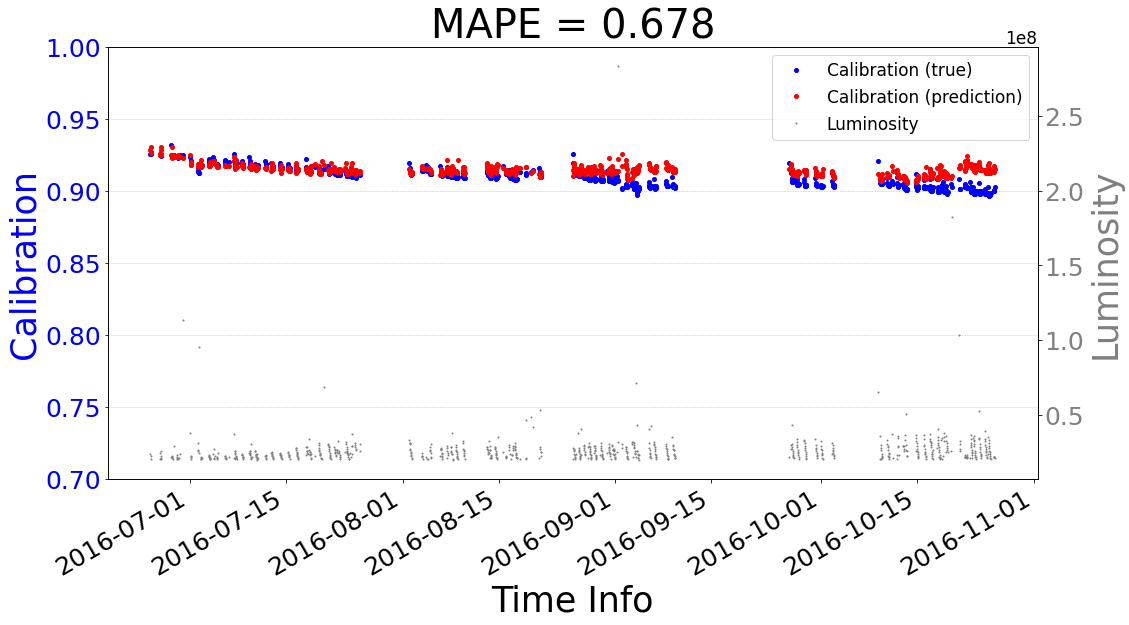

>>> Finish prediction!


In [24]:
# check its prediction on test data
# Please note that here, the data are in the numpy format, not the tensor format
Xtrain = ecal_dataset_prep_test_2016.np_X
Ytrain = ecal_dataset_prep_test_2016.np_Y
df = ecal_dataset_prep_test_2016.df_lumi
scaler_cali = ecal_dataset_prep_test_2016.scaler_cali
year = '2016'
test_case = 'case2'
fig_name_mape = os.path.join(save_dir_case2_fig, '0_MAPE_{}_{}.png'.format(test_case,year))
fig_name_mse = os.path.join(save_dir_case2_fig, '1_MSE_{}_{}.png'.format(test_case,year))
metric_file = os.path.join(save_dir_case2_csv, '{}_{}.csv'.format(test_case,year))
seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                        lstm_decoder,
                                        Xtrain,
                                        Ytrain,
                                        df,
                                        scaler_cali,
                                        device,
                                        fig_name_mape,
                                        fig_name_mse,
                                        metric_file,
                                        test_case)
seq2seq_prediction.start_prediction()

>>>  case2 : start prediction...(be patient)


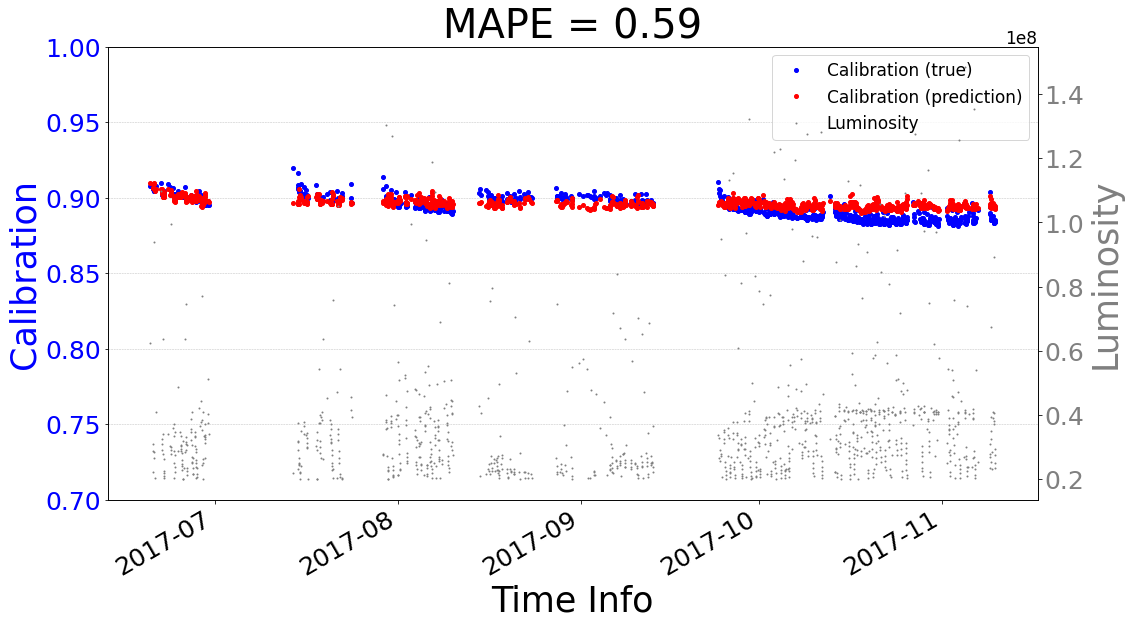

>>> Finish prediction!


In [25]:
# check its prediction on test data-2017
# Please note that here, the data are in the numpy format, not the tensor format
Xtrain = ecal_dataset_prep_test_2017.np_X
Ytrain = ecal_dataset_prep_test_2017.np_Y
df = ecal_dataset_prep_test_2017.df_lumi
scaler_cali = ecal_dataset_prep_test_2017.scaler_cali
year = '2017'
test_case = 'case2'
fig_name_mape = os.path.join(save_dir_case2_fig, '0_MAPE_{}_{}.png'.format(test_case,year))
fig_name_mse = os.path.join(save_dir_case2_fig, '1_MSE_{}_{}.png'.format(test_case,year))
metric_file = os.path.join(save_dir_case2_csv, '{}_{}.csv'.format(test_case,year))
seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                        lstm_decoder,
                                        Xtrain,
                                        Ytrain,
                                        df,
                                        scaler_cali,
                                        device,
                                        fig_name_mape,
                                        fig_name_mse,
                                        metric_file,
                                        test_case)
seq2seq_prediction.start_prediction()

>>>  case2 : start prediction...(be patient)


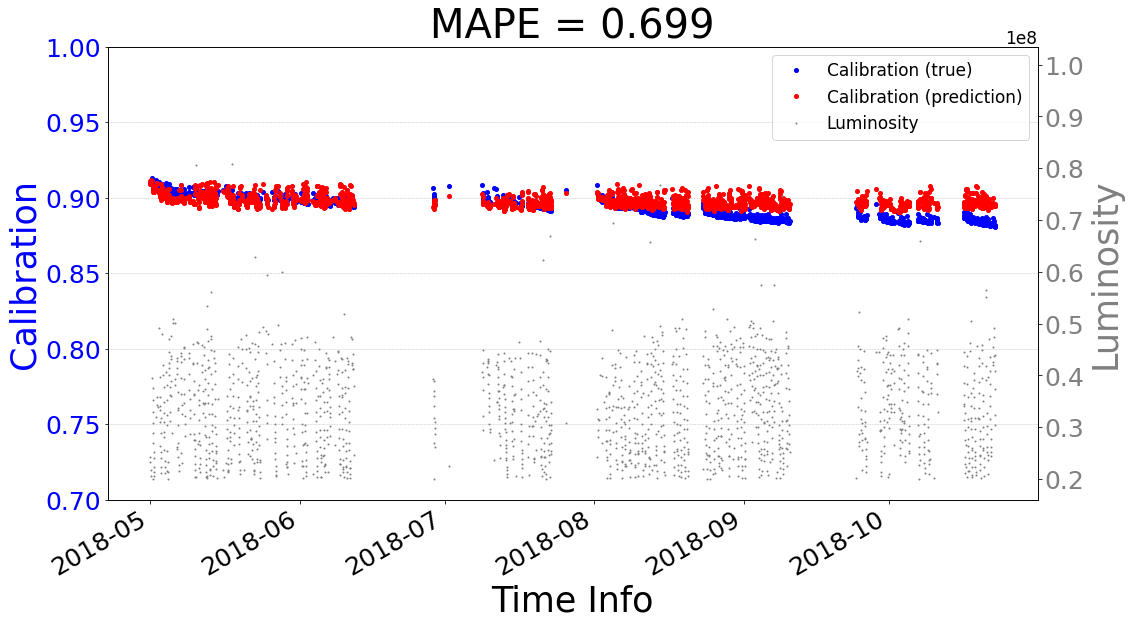

>>> Finish prediction!


In [26]:
# check its prediction on test data-2018
# Please note that here, the data are in the numpy format, not the tensor format
Xtrain = ecal_dataset_prep_test_2018.np_X
Ytrain = ecal_dataset_prep_test_2018.np_Y
df = ecal_dataset_prep_test_2018.df_lumi
scaler_cali = ecal_dataset_prep_test_2017.scaler_cali
year = '2018'
test_case = 'case2'
fig_name_mape = os.path.join(save_dir_case2_fig, '0_MAPE_{}_{}.png'.format(test_case,year))
fig_name_mse = os.path.join(save_dir_case2_fig, '1_MSE_{}_{}.png'.format(test_case,year))
metric_file = os.path.join(save_dir_case2_csv, '{}_{}.csv'.format(test_case,year))
seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                        lstm_decoder,
                                        Xtrain,
                                        Ytrain,
                                        df,
                                        scaler_cali,
                                        device,
                                        fig_name_mape,
                                        fig_name_mse,
                                        metric_file,
                                        test_case)
seq2seq_prediction.start_prediction()